In [1]:
import os
import pickle
import gzip
import numpy as np
import pandas as pd

import tensorflow as tf
#tf.enable_eager_execution()

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib notebook
from tensorflow_cfr.tfutils.TFRprovider import DatasetProvider


In [2]:
# Some helper code
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        self.slices, rows, cols  = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[self.ind, :, :], cmap = 'gray')
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[self.ind, :, :])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

### Recover data from TFRecords ###

In [3]:
# Directories and files
data_root = os.path.normpath('/tf/data')
image_dir = os.path.normpath('/tf/imagedata')

# TFR file
tfr_file = os.path.join(image_dir, 'test_a4c_laocc_1_p0.tfrecords')
csv_file = os.path.join(image_dir, 'test_a4c_laocc_1_p0.csv')

# Load .csv file 
df = pd.read_csv(csv_file)
print(df[['mode', 'cfr', 'frames', 'rows', 'cols', 'tfr_file', 'record_ID']].head(10))

   mode       cfr  frames  rows  cols                       tfr_file  record_ID
0  test  2.427729      30   422   636  test_a4c_laocc_1_p0.tfrecords          0
1  test  2.517834      30   480   640  test_a4c_laocc_1_p0.tfrecords          1
2  test  2.086871      30   600   800  test_a4c_laocc_1_p0.tfrecords          2
3  test  1.800502      30   422   636  test_a4c_laocc_1_p0.tfrecords          3
4  test  1.498263      30   600   800  test_a4c_laocc_1_p0.tfrecords          4
5  test  2.147992      30   600   800  test_a4c_laocc_1_p0.tfrecords          5
6  test  1.634950      30   434   636  test_a4c_laocc_1_p0.tfrecords          6
7  test  3.615059      30   434   636  test_a4c_laocc_1_p0.tfrecords          9
8  test  2.458809      30   434   636  test_a4c_laocc_1_p0.tfrecords         10
9  test  1.415959      30   434   636  test_a4c_laocc_1_p0.tfrecords         13


### Percentile thresholds for classification ###

In [4]:
# Get the percentile thresholds for the data we have
df_cfr = pd.read_csv(os.path.join(image_dir, 'Identifier_CFR_study_round1-2-3_a2c_ft_hashed_mrn.txt'), sep = '\t')
print('Size of cfr table:', df_cfr.shape)
cfr_array = df_cfr.cfr.values
p_list = [np.round(np.percentile(cfr_array, p), decimals = 3) for p in (25, 50, 75)]
print('Percentile boundaries:', p_list)

Size of cfr table: (17168, 5)
Percentile boundaries: [1.248, 1.564, 2.06]


In [5]:
p_list = [np.round(np.percentile(cfr_array, p), decimals = 3) for p in (25, 50, 75)]
percentile_list = sorted(p_list)
print('Percentile boundaries:', p_list)

Percentile boundaries: [1.248, 1.564, 2.06]


In [6]:
def cfr_label(cfr_value):
    if cfr_value < percentile_list[0]:
        label = 0
    elif cfr_value >= percentile_list[-1]:
        label = len(percentile_list)
    
    for p in range(1, len(percentile_list)):
        
        if (cfr_value >= percentile_list[p-1]) & (cfr_value < percentile_list[p]):
            label = p
    
    return label

df['label'] = df['cfr'].apply(cfr_label)
print(df.label.iloc[0:10].values)

[3 3 3 2 1 3 2 3 3 1]


In [7]:
percentile_list = p_list
def cfr_p_label(cfr_value):
    return np.digitize(cfr_value, bins = percentile_list)
# Setting the threshold, check the number of positives and negatives
df['labelp'] = df['cfr'].apply(cfr_p_label)
print(df.labelp.iloc[0:10].values)

[3 3 3 2 1 3 2 3 3 1]


In [8]:
label_list = sorted(df.label.unique())
print('Unique labels:', label_list)
df.head(20)
# Number of samples in each group
samples = [df[df.label == l].shape[0] for l in label_list]
for l in label_list:
    print('Label:', l, 'samples:', samples[l])

Unique labels: [0, 1, 2, 3]
Label: 0 samples: 103
Label: 1 samples: 128
Label: 2 samples: 83
Label: 3 samples: 187


In [9]:
# Load from tfrecords
ds = DatasetProvider([tfr_file],
                     repeat_count = 1,
                     n_frames = 30,
                     cfr_boundaries = p_list,
                     output_height = 299,
                     output_width = 299,
                     cat_reg_outputs = True,
                     rgb = False)

batch_size = 8
ds = ds.make_batch(batch_size = batch_size, shuffle = False)

W0604 18:16:52.512552 140175698695936 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/image_ops_impl.py:1444: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [10]:
print(df[['mode', 'cfr', 'label', 'frames', 'rows', 'cols', 'tfr_file', 'record_ID']].head(10))

   mode       cfr  label  frames  rows  cols                       tfr_file  record_ID
0  test  2.427729      3      30   422   636  test_a4c_laocc_1_p0.tfrecords          0
1  test  2.517834      3      30   480   640  test_a4c_laocc_1_p0.tfrecords          1
2  test  2.086871      3      30   600   800  test_a4c_laocc_1_p0.tfrecords          2
3  test  1.800502      2      30   422   636  test_a4c_laocc_1_p0.tfrecords          3
4  test  1.498263      1      30   600   800  test_a4c_laocc_1_p0.tfrecords          4
5  test  2.147992      3      30   600   800  test_a4c_laocc_1_p0.tfrecords          5
6  test  1.634950      2      30   434   636  test_a4c_laocc_1_p0.tfrecords          6
7  test  3.615059      3      30   434   636  test_a4c_laocc_1_p0.tfrecords          9
8  test  2.458809      3      30   434   636  test_a4c_laocc_1_p0.tfrecords         10
9  test  1.415959      1      30   434   636  test_a4c_laocc_1_p0.tfrecords         13


In [11]:
for out in ds.take(1):
    output_batch = out
    

# Output batch is a list of dictionaries [INPUT, OUTPUT]:
print('Input keys: ', output_batch[0].keys())
print('Output keys:', output_batch[1].keys())

image_batch = output_batch[0]['video'].numpy()
print('Video batch shape:', image_batch.shape)
class_label_batch = output_batch[1]['class_output'].numpy()
print('Class batch output shape:', class_label_batch.shape)
cfr_batch = output_batch[1]['score_output'].numpy()
print('CFR batch output shape:', cfr_batch.shape)

Input keys:  dict_keys(['video'])
Output keys: dict_keys(['class_output', 'score_output'])
Video batch shape: (8, 30, 299, 299, 1)
Class batch output shape: (8, 4)
CFR batch output shape: (8,)


In [12]:
# Pick a random sample from the batch
#sample_idx = np.random.randint(batch_size, size = 1)[0]
sample_idx = 1

# Image sample
video_sample = image_batch[sample_idx]
class_label_onehot = class_label_batch[sample_idx]
class_label = np.argmax(class_label_onehot)

print('Batch sample:', sample_idx)
print('Video shape:', video_sample.shape)
print('class label:', class_label)

#Pick a few images and check the stats
image_idx_list = np.random.randint(video_sample.shape[0], size = 10)
for frame in image_idx_list:
    im = video_sample[frame]
    print()
    print('frame:', frame)
    print('min:', np.amin(im))
    print('max:', np.amax(im))
    print('mean:', np.mean(im))
    print('std:', np.std(im))
    print('color channels:', im[20, 20, :])

Batch sample: 1
Video shape: (30, 299, 299, 1)
class label: 3

frame: 11
min: -0.5344775
max: 6.3957963
mean: -9.0118014e-08
std: 0.99999976
color channels: [-0.5344775]

frame: 18
min: -0.54096854
max: 6.3461456
mean: -8.4656314e-08
std: 0.9999998
color channels: [-0.54096854]

frame: 27
min: -0.53192234
max: 6.7147655
mean: -1.501967e-07
std: 0.99999976
color channels: [-0.53192234]

frame: 25
min: -0.5452948
max: 6.3941355
mean: -1.44735e-07
std: 0.9999997
color channels: [-0.5452948]

frame: 8
min: -0.54749036
max: 6.0523963
mean: -1.0650311e-07
std: 0.99999976
color channels: [-0.54749036]

frame: 18
min: -0.54096854
max: 6.3461456
mean: -8.4656314e-08
std: 0.9999998
color channels: [-0.54096854]

frame: 22
min: -0.5476099
max: 6.1141214
mean: -2.1846791e-08
std: 0.9999999
color channels: [-0.5476099]

frame: 11
min: -0.5344775
max: 6.3957963
mean: -9.0118014e-08
std: 0.99999976
color channels: [-0.5344775]

frame: 15
min: -0.53140545
max: 6.71276
mean: -1.283499e-07
std: 0.999999

<IPython.core.display.Javascript object>


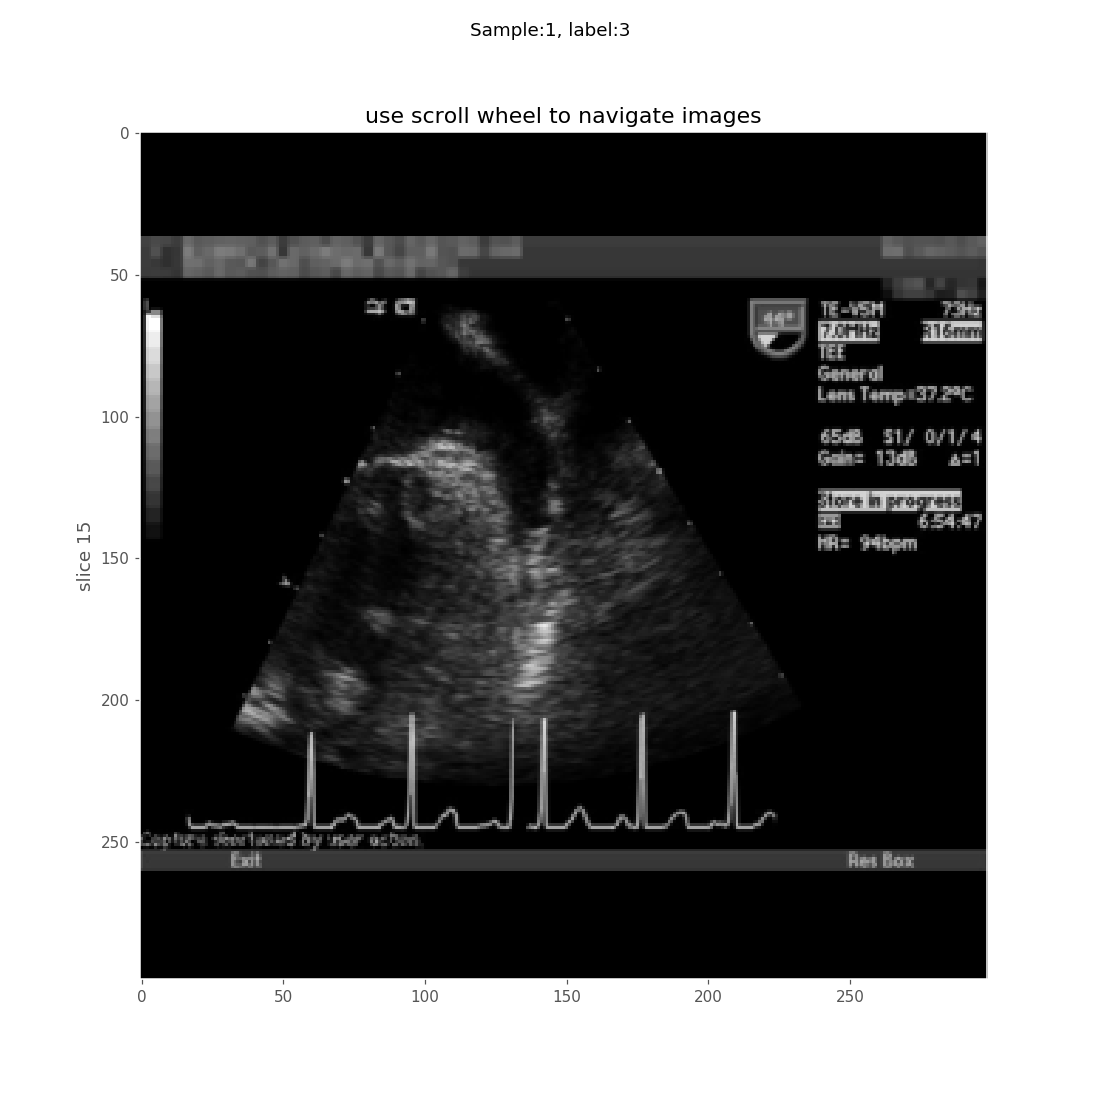

In [13]:
%matplotlib notebook
im_stack = np.squeeze(video_sample[:, :, :, 0])
fig, ax = plt.subplots(figsize = (10, 10))
ax.grid(False)
tracker = IndexTracker(ax, im_stack)
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.suptitle(('Sample:{s}, label:{l}').format(s = sample_idx, l = class_label))
plt.show()